# 機械学習帳 確認問題(10.10)

[機械学習帳の非階層的クラスタリングの確認問題(10.10)](https://chokkan.github.io/mlnote/classification/04nntrain.html#id13)を解きます。

## 講義内容の復習

![chapter10-1.svg](./images/chapter10/chapter10-1.svg)

![chapter10-2.svg](./images/chapter10/chapter10-2.svg)

## 1. データセットの読み込み

[教育用標準データセット（SSDSE）](https://www.nstac.go.jp/use/literacy/ssdse/)に収録されている都道府県庁所在市別・家計消費データ（SSDSE-C）に対してクラスタ分析を適用し、消費行動が類似している都道府県のクラスタを作りたい。

このデータセットを読み込み、各都道府県庁所在地を特徴ベクトルで表現せよ。

SSDSEのサイトから、SSDSE-家計消費（SSDSE-C）のURLを確認し、CSVファイルを`data`フォルダにダウンロードする。

In [1]:
URL = "https://www.nstac.go.jp/sys/files//SSDSE-C-2022.csv"

In [2]:
import urllib
from pathlib import Path


csv = urllib.request.urlopen(URL).read().decode("shift-jis")
csv_path = Path("./data/ssdse-c-2022.csv")
with csv_path.open(mode="w", encoding="utf-8") as f:
    f.write(csv)

データを表す特徴ベクトルを決める。今回はLB12「外食」の中分類に注目し、外食に所属する品目のデータを特徴量とする。
データ項目の意味は[「SSDSE-家計消費の解説」](https://www.nstac.go.jp/sys/files//kaisetsu-C-2022.pdf)に記載されている。地域項目を除くデータ項目は226であり、食料品の中分類、小分類、品目ごとにコードが採番され列項目として定義されている。値は2019年から2021年の1世帯当たりの年間支出金額の平均値である。

留意する点として、都道府県庁所在地は計47しかないため、県庁所在地+全国(行)に比べデータ項目(列)が非常に多いデータといえる。今回は「消費行動」の類似性を調べるため、消費行動が顕著に表れる項目に絞ることを考えたい。外食は地域ごとの飲食店数や所得の影響が反映され消費行動の差として現れると推察されることから、「外食」の項目を選択した。

In [3]:
import pandas as pd


raw_df = pd.read_csv(csv_path)
raw_df.head(5)

,SSDSE-C-2022,Prefecture,City,LA03,LB00,LB01,LB011001,LB012001,LB012002,LB013001,...,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
0,地域コード,都道府県,市,世帯人員,食料（合計）,01 穀類,米,食パン,他のパン,生うどん・そば,...,すし（外食）,和食,中華食,洋食,焼肉,ハンバーガー,他の主食的外食,喫茶代,飲酒代,学校給食
1,R00000,全国,全国,2.95,960240,79678,22998,10163,21494,3513,...,13620,19716,4179,9794,6184,5067,44164,6522,11358,9713
2,R01100,北海道,札幌市,2.84,942332,82566,29665,9367,18496,3214,...,16906,22845,3772,15761,7132,4187,20326,5462,14817,13273
3,R02201,青森県,青森市,2.87,892205,73320,21932,8285,17063,3164,...,12594,13802,2748,6796,5794,3991,14162,2833,6874,9698
4,R03201,岩手県,盛岡市,3.12,937554,79379,23297,8402,20278,3435,...,11490,9847,1826,5333,4951,3884,35759,4046,11100,10647


読み込んだCSVデータから不要な行/列を削除する。

In [4]:
code_name = raw_df.iloc[0,:]  # コードの名称記載行を取得
df = raw_df.drop(0, axis=0) # 不要な行の削除
location_name = df.iloc[:,:3]  # 県庁所在地名を取得
df = df.drop(["Prefecture", "City"], axis=1) # 不要な列の削除
df = df.set_index("SSDSE-C-2022")  # 県庁所在地のコードをindexにする
df = df.astype("float32")  # 数値型に変換

ターゲットとする外食の品目の身に絞り込む。外食の品目コードはLB12である。

In [5]:
TARGET_CATEGORY = "LB12"

In [6]:
feature_df = df[[c for c in df.columns if c.startswith(TARGET_CATEGORY) and len(c) > len(TARGET_CATEGORY)]]

地域ごとの世帯数でばらつきが出ないよう、世帯人数で割り一人当たりの支出金額とする。

In [7]:
feature_df = feature_df.divide(df["LA03"], axis=0)

都道府県庁所在市の特徴ベクトルの表現を次の通りとした。

In [8]:
feature_df.head(5)

,LB121101,LB121102,LB121103,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
SSDSE-C-2022,,,,,,,,,,,,,
R00000,1855.593140,2080.338867,709.830505,4616.949219,6683.389648,1416.610107,3320.000000,2096.271240,1717.627075,14970.847656,2210.847412,3850.169434,3292.542236
R01100,1965.140869,2357.394531,573.943665,5952.816895,8044.014160,1328.169067,5549.647949,2511.267578,1474.295776,7157.042480,1923.239502,5217.253906,4673.591797
R02201,1604.529663,3312.892090,282.926849,4388.153320,4809.059570,957.491333,2367.944336,2018.815430,1390.592407,4934.495117,987.108032,2395.122070,3379.094238
R03201,1747.756470,2740.705322,565.384644,3682.692383,3156.089844,585.256409,1709.294922,1586.859009,1244.871826,11461.218750,1296.794922,3557.692383,3412.500244
R04100,2191.666748,3111.000000,817.333313,4128.000000,5340.666504,963.333313,2513.333252,2024.333374,1528.333374,11679.000000,1699.000000,2665.333252,3059.000000


## 2. WCSSのプロット

K-meansクラスタリングを異なるクラスタ数で実行し、横軸にクラスタ数、縦軸にK-meansの目的関数の値、すなわちクラスタ内平方和（WCSS: within-cluster sum-of-squares）をプロットしたグラフを描画せよ。

K-meansクラスタを実行する関数を作成する。

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def kmeans(X, n_clusters=3, normalize=True):
    _X = X
    if normalize:
        _X = StandardScaler().fit_transform(X)

    model = KMeans(n_clusters).fit(_X)
    return model

クラスタ数ごとのWCSSの値をプロットする。[scikit-learnのドキュメントから](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)、`inertia_`にSum of squared distances、つまりWCSSが取得できることを確認できる。

In [10]:
import pandas as pd


num_clusters = range(2, 10)
models = []
for n_clusters in num_clusters:
    model = kmeans(feature_df, n_clusters=n_clusters, normalize=True)
    models.append(model)

<AxesSubplot:>

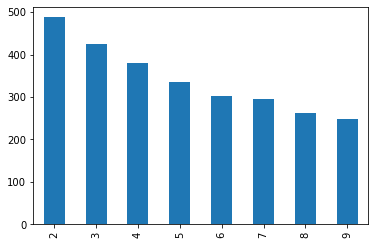

In [11]:
pd.Series(data=[m.inertia_ for m in models], name="wcss", index=list(num_clusters)).plot.bar()

## 3. K-meansクラスタリング

(2)の結果に基づき、クラスタ数を適当に選び、K-meansクラスタリングを実行せよ。からまでの各クラスタに対して、それぞれ所属する都道府県庁所在地を明らかにせよ。

クラスタ数が7ぐらいからWCSSの低下スピードが下がっているように見えるため、クラスタ数7で分類を行ってみる。

In [12]:
target_n_clusters = 7

In [13]:
model = None
wcss_bar = 0
for trial in range(100):
    _model = kmeans(feature_df, n_clusters=target_n_clusters, normalize=True)
    if model is None or _model.inertia_ < wcss_bar:
        model = _model
        wcss_bar = _model.inertia_

クラスタへの割り当て結果を参照する。クラスタへの割り当て結果は、[scikit-learnのドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)より`labels_`で確認できる。

In [14]:
cluster_df = pd.merge(
    feature_df.assign(Cluster=model.labels_),
    location_name.set_index("SSDSE-C-2022"),
    left_index=True, right_index=True)
cluster_df.sort_values("Cluster")[["Cluster", "Prefecture", "City"]]

,Cluster,Prefecture,City
SSDSE-C-2022,,,
R47201,0,沖縄県,那覇市
R42201,0,長崎県,長崎市
R38201,0,愛媛県,松山市
R30201,0,和歌山県,和歌山市
R01100,1,北海道,札幌市
R46201,1,鹿児島県,鹿児島市
R20201,1,長野県,長野市
R19201,1,山梨県,甲府市
R18201,1,福井県,福井市


各クラスタを決定づける特徴を確認したい。クラスタの番号をラベルとして予測モデルを構築し、特徴量の重要度からクラスタの分類に寄与している特徴を発見する。

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier())
])

pipeline.fit(cluster_df.drop(columns=["Prefecture", "City", "Cluster"]), cluster_df["Cluster"])

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

In [16]:
# To get feature name of pipeline, please refer https://github.com/scikit-learn/scikit-learn/issues/22093
importance_df = pd.DataFrame({
    "importance": pipeline["model"].feature_importances_,
    "id": pipeline[:-1].get_feature_names_out(),
    "name": code_name[pipeline[:-1].get_feature_names_out()]
})

In [17]:
importance_df.sort_values("importance", ascending=False)

,importance,id,name
LB121101,0.117765,LB121101,日本そば・うどん
LB121107,0.105682,LB121107,洋食
LB121102,0.098238,LB121102,中華そば
LB121201,0.097323,LB121201,喫茶代
LB121104,0.096774,LB121104,すし（外食）
LB121110,0.084671,LB121110,他の主食的外食
LB122001,0.082057,LB122001,学校給食
LB121106,0.069530,LB121106,中華食
LB121105,0.066891,LB121105,和食
LB121109,0.053465,LB121109,ハンバーガー


日本そば・うどん、中華そばといった麺類がクラスタを決定づけている傾向が見える。(※クラスタリングの結果は変わるので、重要な特徴も実行のたびに変わる可能性がある)